# Setup


In [20]:
%conda install pytorch torchvision torchaudio cudatoolkit = 11.3 - c pytorch

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.
^C

Note: you may need to restart the kernel to use updated packages.


In [14]:
%conda install pandas matplotlib

Solving environment: ...working... done

## Package Plan ##

  environment location: d:\Users\zhuan\anaconda3\envs\behaviourclone

  added / updated specs:
    - matplotlib
    - pandas


The following NEW packages will be INSTALLED:

  brotli             pkgs/main/win-64::brotli-1.0.9-ha925a31_2
  cycler             pkgs/main/noarch::cycler-0.11.0-pyhd3eb1b0_0
  fonttools          pkgs/main/noarch::fonttools-4.25.0-pyhd3eb1b0_0
  icu                pkgs/main/win-64::icu-58.2-ha925a31_3
  kiwisolver         pkgs/main/win-64::kiwisolver-1.4.2-py39hd77b12b_0
  matplotlib         pkgs/main/win-64::matplotlib-3.5.1-py39haa95532_1
  matplotlib-base    pkgs/main/win-64::matplotlib-base-3.5.1-py39hd77b12b_1
  munkres            pkgs/main/noarch::munkres-1.1.4-py_0
  pyqt               pkgs/main/win-64::pyqt-5.9.2-py39hd77b12b_6
  qt                 pkgs/main/win-64::qt-5.9.7-vc14h73c81de_0
  sip                pkgs/main/win-64::sip-4.19.13-py39hd77b12b_0


Preparing transaction: ...working...

In [1]:
%pip install wandb

     ---------------------------------------- 1.8/1.8 MB 9.6 MB/s eta 0:00:00
  Using cached docker_pycreds-0.4.0-py2.py3-none-any.whl (9.0 kB)
     -------------------------------------- 146.4/146.4 kB 9.1 MB/s eta 0:00:00
  Using cached GitPython-3.1.27-py3-none-any.whl (181 kB)
  Using cached promise-2.3-py3-none-any.whl
  Using cached pathtools-0.1.2-py3-none-any.whl
  Using cached click-8.1.3-py3-none-any.whl (96 kB)
  Using cached PyYAML-6.0-cp39-cp39-win_amd64.whl (151 kB)
     ------------------------------------- 904.1/904.1 kB 19.0 MB/s eta 0:00:00
  Using cached gitdb-4.0.9-py3-none-any.whl (63 kB)
  Using cached smmap-5.0.0-py3-none-any.whl (24 kB)
Note: you may need to restart the kernel to use updated packages.


In [11]:
import os, time, copy
import pandas as pd
from PIL import Image, ImageFilter
import numpy as np
import matplotlib.pyplot as plt
import wandb

import torch
import torchvision
import torch.nn as nn
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import datasets, transforms, utils, models
import torch.optim as optim
from torch.optim import lr_scheduler

In [2]:
IMG_SIZE = (224, 224)
DATA_DIR = 'data'
EPOCHS = 25
LEARNING_RATE = 0.001
MOMENTUM = 0.9
STEP_SIZE = 7
GAMMA = 0.1

In [3]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: eddiezhuang. Use `wandb login --relogin` to force relogin


True

In [4]:
wandb.init(project="paper-io-ai", config={
    "epochs": EPOCHS,
    "learning_rate": LEARNING_RATE,
    "momentum": MOMENTUM,
    "step_size": STEP_SIZE,
    "gamma": GAMMA
})

# Load Data


In [18]:
data_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])
])

data = datasets.ImageFolder(DATA_DIR, data_transforms)

train_size = int(0.8 * len(data))
val_size = len(data) - train_size

train_data, val_data = torch.utils.data.random_split(
    data, [train_size, val_size])
image_datasets = {
    'train': train_data,
    'val': val_data
}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = data.classes

device = torch.device("cuda:0")
torch.cuda.get_device_name(device)

'NVIDIA GeForce GTX 1650'

# Visualize Images

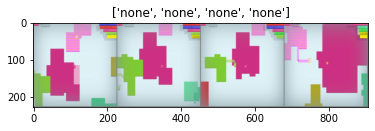

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485])
    std = np.array([0.229])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Train Model


In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=EPOCHS):
    wandb.watch(model, log_freq=100)

    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device) # load data to GPU
                labels = labels.to(device)

                optimizer.zero_grad() # clear gradients for this training step

                with torch.set_grad_enabled(phase == 'train'):
                    # Calculate loss
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            wandb.log({"loss": epoch_loss, "acc": epoch_acc})

            # save the model if it is the best so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    wandb.log({"best_acc": best_acc})

    model.load_state_dict(best_model_wts)
    return model

In [13]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_df = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=STEP_SIZE, gamma=GAMMA)

In [19]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, EPOCHS)

Epoch 1/25
----------
train Loss: 0.6687 Acc: 0.8493
val Loss: 0.6187 Acc: 0.8703

Epoch 2/25
----------
train Loss: 0.5772 Acc: 0.8435
val Loss: 0.5935 Acc: 0.8410

Epoch 3/25
----------
train Loss: 0.4948 Acc: 0.8498
val Loss: 0.4480 Acc: 0.8452

Epoch 4/25
----------
train Loss: 0.3854 Acc: 0.8587
val Loss: 0.4900 Acc: 0.8138

Epoch 5/25
----------
train Loss: 0.3126 Acc: 0.8807
val Loss: 0.3980 Acc: 0.8598

Epoch 6/25
----------
train Loss: 0.2756 Acc: 0.8943
val Loss: 0.3878 Acc: 0.8473

Epoch 7/25
----------
train Loss: 0.2114 Acc: 0.9158
val Loss: 0.4755 Acc: 0.8285

Epoch 8/25
----------
train Loss: 0.1418 Acc: 0.9419
val Loss: 0.3583 Acc: 0.8577

Epoch 9/25
----------
train Loss: 0.1057 Acc: 0.9639
val Loss: 0.3235 Acc: 0.8787

Epoch 10/25
----------
train Loss: 0.0808 Acc: 0.9681
val Loss: 0.3129 Acc: 0.8703

Epoch 11/25
----------
train Loss: 0.0744 Acc: 0.9728
val Loss: 0.3201 Acc: 0.8682

Epoch 12/25
----------
train Loss: 0.0645 Acc: 0.9822
val Loss: 0.3683 Acc: 0.8577

E

# Visualize Model Predictions

In [29]:
def visualize_model(model, num_images=6):
    """Shows predictions for a few images"""
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad(): # Reduces memory consumption for inference
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1) # Returns the max output

            for j in range(inputs.size()[0]):
                images_so_far += 1

                # // divides and only keeps the integer part
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

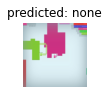

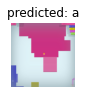

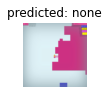

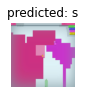

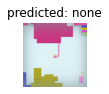

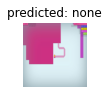

In [30]:
visualize_model(model_ft)

# Save Model


In [31]:
torch.save(model_ft.state_dict(), os.path.join(wandb.run.dir, 'model.pth'))

In [33]:
wandb.finish()

acc,▂▃▂▃▂▂▂▁▄▃▂▅▂▃▇▄▇▇▃██▃██▃██▃█▃▃█▃▃█▃▃█▃▃
best_acc,▁
loss,█▇█▇▇▆▅▆▄▅▅▃▆▄▂▄▁▁▄▁▁▄▁▁▅▁▁▄▁▄▅▁▄▅▁▄▄▁▄▄
acc,0.86611
best_acc,0.87866
loss,0.35378
